# Training with ResNet

Reduced tomatos images to 1900.
Doubled the Raspberrys.
and then applied test-validation-train split.

Fine tuning freezing the first 4 layers.

We tried also a previous ResNet with similar characteristics, but this version is performing better.

Probabily the results where worse then what we expected because we used an higher learning rate, in particular for the fine tuning.
We figure out later that we could have reduced it a bit

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!unzip ../gdrive/MyDrive/Challenge1_Mio/ResNetTest/resnet_dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resnet_dataset/train/Blueberry/01924.jpg  
  inflating: resnet_dataset/train/Blueberry/02066.jpg  
  inflating: resnet_dataset/train/Blueberry/01936.jpg  
  inflating: resnet_dataset/train/Blueberry/01909.jpg  
  inflating: resnet_dataset/train/Blueberry/01697.jpg  
  inflating: resnet_dataset/train/Blueberry/02074.jpg  
  inflating: resnet_dataset/train/Blueberry/02140.jpg  
  inflating: resnet_dataset/train/Blueberry/02183.jpg  
  inflating: resnet_dataset/train/Blueberry/02188.jpg  
  inflating: resnet_dataset/train/Blueberry/02093.jpg  
  inflating: resnet_dataset/train/Blueberry/02225.jpg  
  inflating: resnet_dataset/train/Blueberry/01889.jpg  
  inflating: resnet_dataset/train/Blueberry/02223.jpg  
  inflating: resnet_dataset/train/Blueberry/01781.jpg  
  inflating: resnet_dataset/train/Blueberry/01668.jpg  
  inflating: resnet_dataset/train/Blueberry/02147.jpg  
  inflating: resnet_dataset/train/Blueberry/01786.jpg 

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'resnet_dataset'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

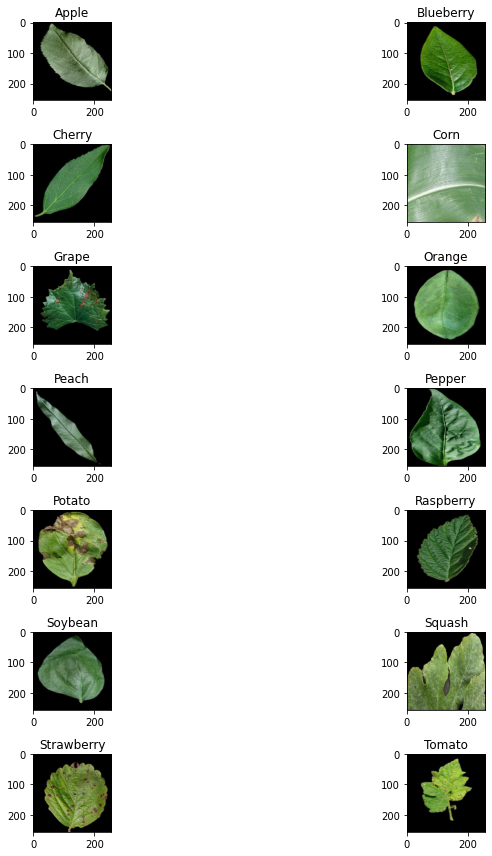

In [ ]:
# Plot example images from dataset
labels = labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry', 'Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))

for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


#Data Generator

Import:

In [ ]:
cd /content

/content


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0, preprocessing_function=preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)


Found 10645 images belonging to 14 classes.
Found 2124 images belonging to 14 classes.
Found 1430 images belonging to 14 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model used:
# Layout
def build_model(input_shape):

  supernet = ResNet50(input_shape=(256, 256, 3),weights='imagenet', include_top=False)
  # supernet.trainable = False

  input_layer = tfkl.Input(shape=input_shape, name='Input')
  x = supernet(input_layer)
  x = tfkl.Flatten(name='Flattening')(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)  
  output_layer = tfkl.Dense(
      14, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


  return model


In [ ]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 31.1 MB/s 


94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 14)                1835022   
                                                                 
Total params: 25,422,734
Trainable params: 25,369,614
Non-trainable params: 53,120
_____________________________________________

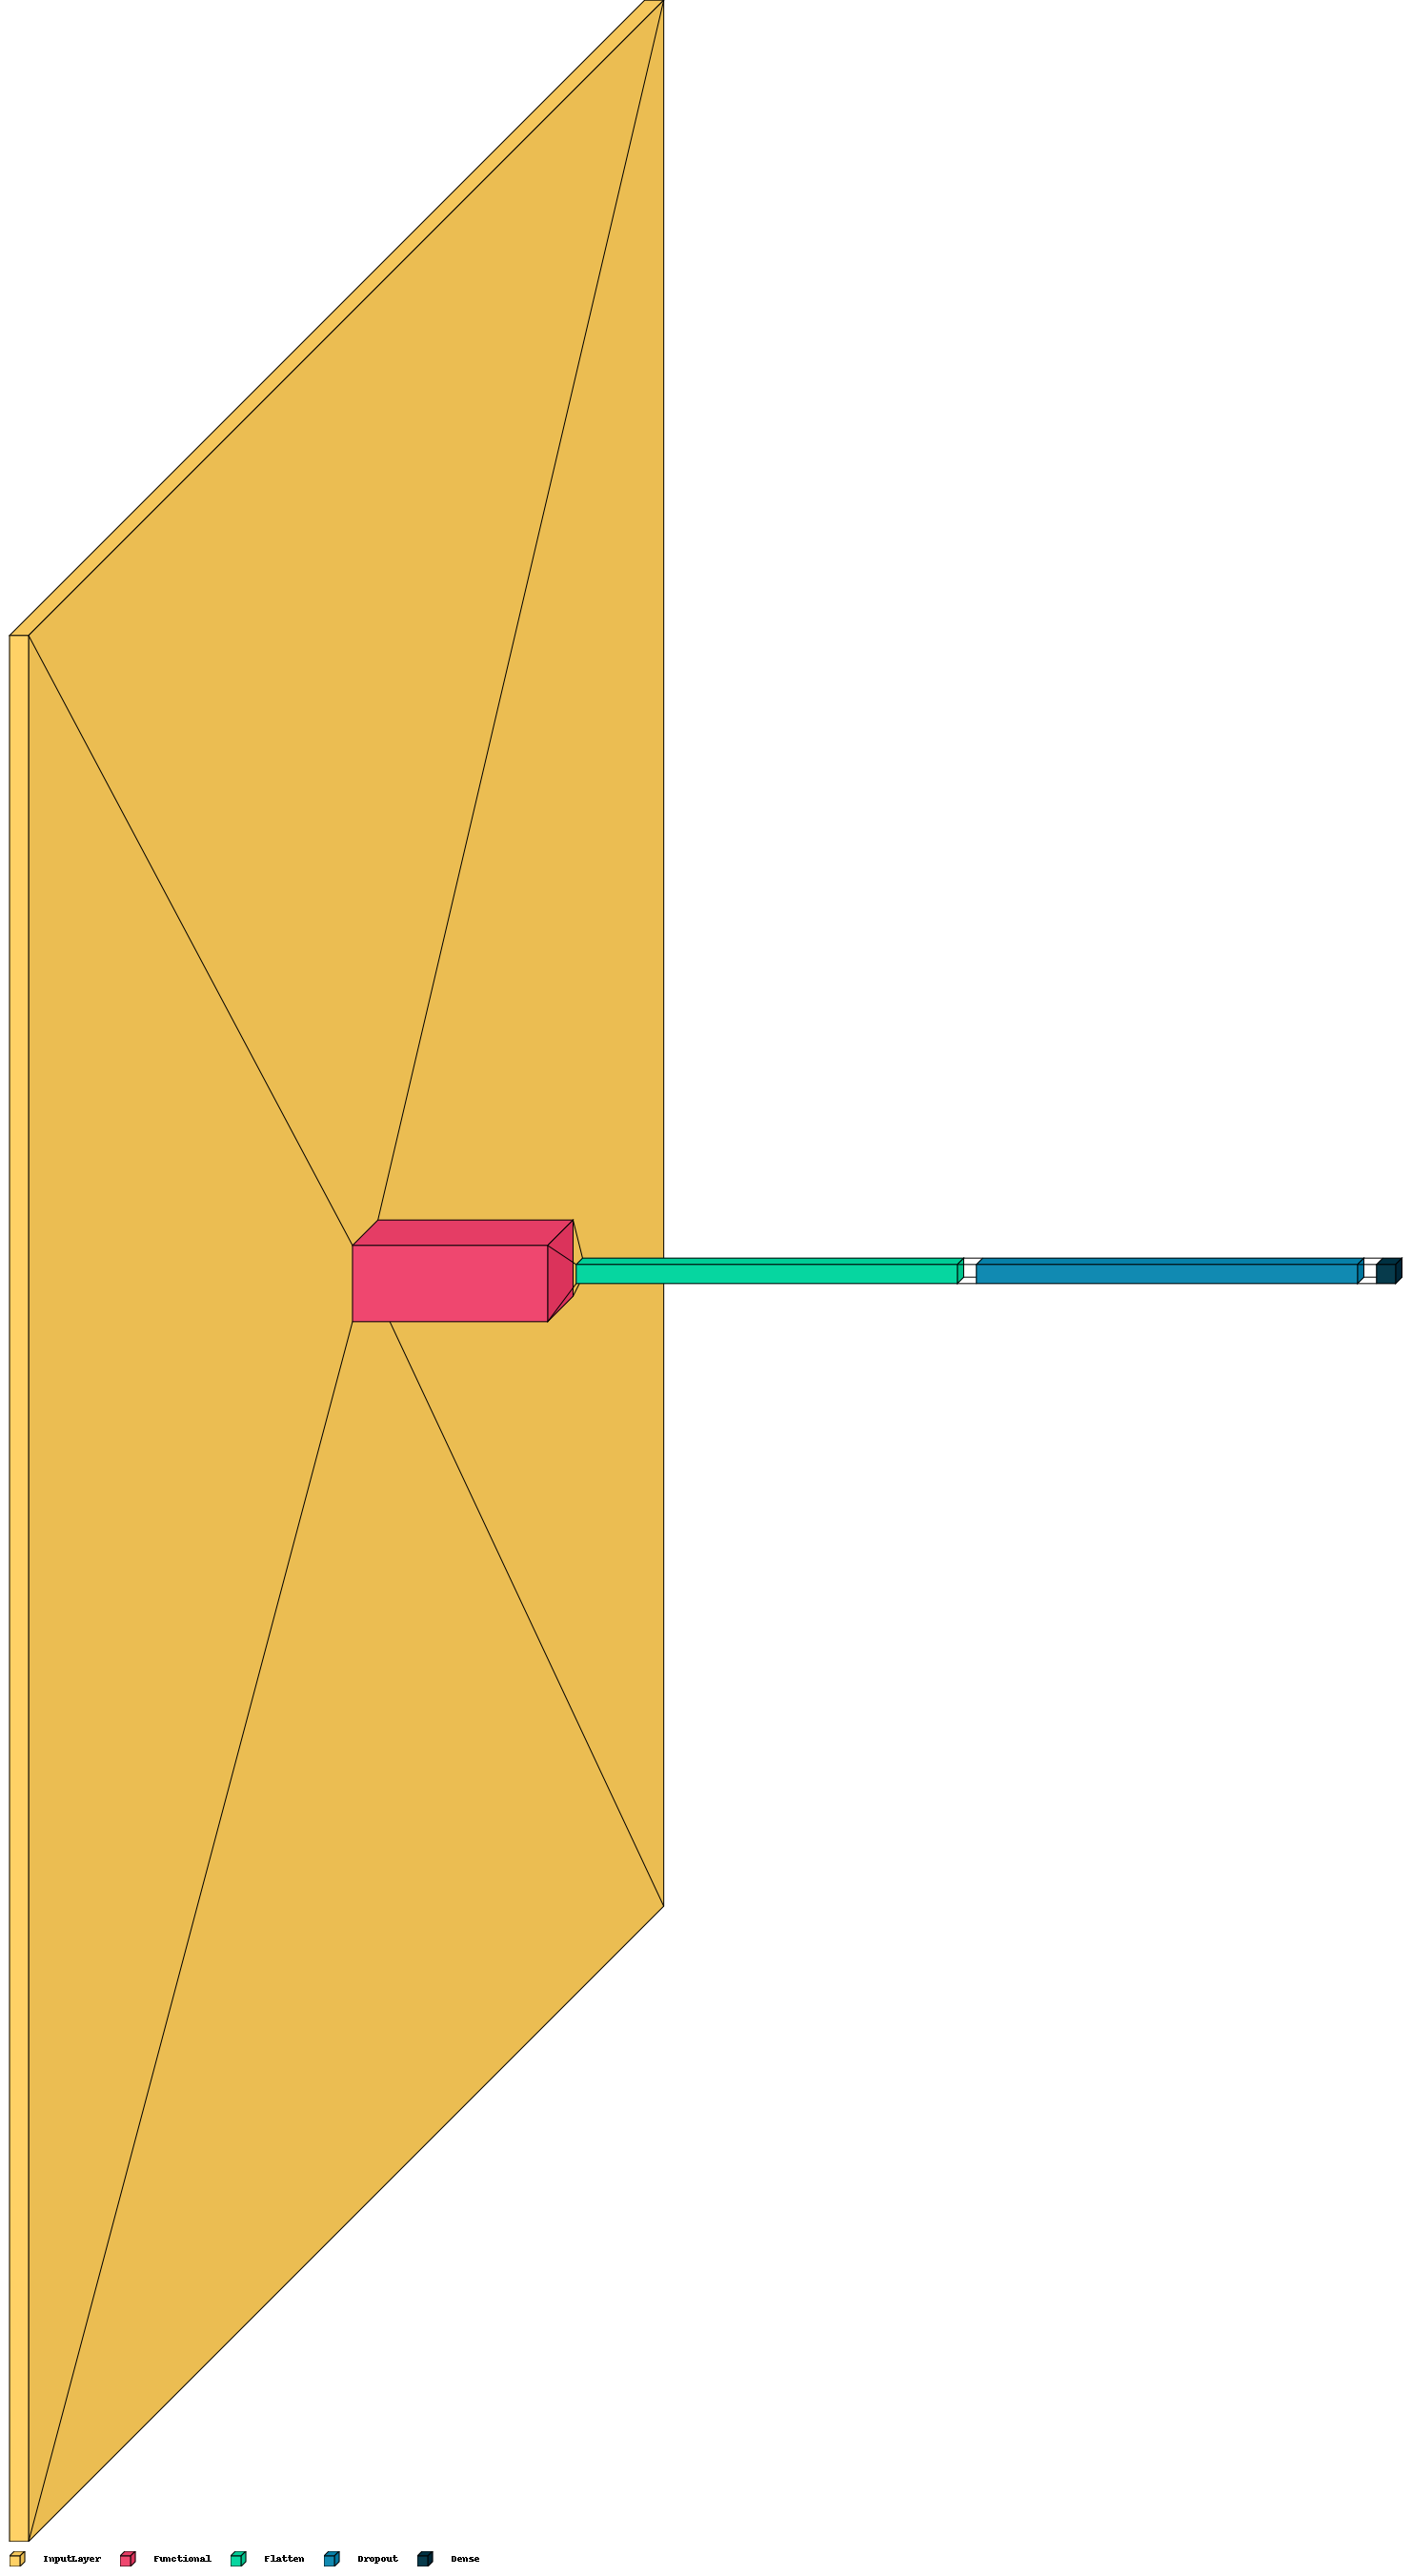

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
   layer.trainable = False

for i, layer in enumerate(model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 14)                1835022   
                                                                 
Total params: 25,422,734
Trainable params: 1,835,022
Non-trainable params: 23,587,712
_________________________________________________________________


# Save checkpoints

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/ResNetTest/Checkpts/Check') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Training the model

In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='resnet_checks')

# Create folders and callbacks and fit
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
666/666 [==============================] - ETA: 0s - loss: 3.6880 - accuracy: 0.2234 - precision: 0.4215 - recall: 0.0865

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 178s 235ms/step - loss: 3.6880 - accuracy: 0.2234 - precision: 0.4215 - recall: 0.0865 - val_loss: 4.4231 - val_accuracy: 0.2119 - val_precision: 0.3083 - val_recall: 0.1893
Epoch 2/200
666/666 [==============================] - ETA: 0s - loss: 1.7860 - accuracy: 0.4343 - precision: 0.7037 - recall: 0.2472

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 154s 231ms/step - loss: 1.7860 - accuracy: 0.4343 - precision: 0.7037 - recall: 0.2472 - val_loss: 2.8594 - val_accuracy: 0.4204 - val_precision: 0.4703 - val_recall: 0.3950
Epoch 3/200
666/666 [==============================] - ETA: 0s - loss: 1.4353 - accuracy: 0.5429 - precision: 0.7345 - recall: 0.3818

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 154s 231ms/step - loss: 1.4353 - accuracy: 0.5429 - precision: 0.7345 - recall: 0.3818 - val_loss: 4.5276 - val_accuracy: 0.2994 - val_precision: 0.3002 - val_recall: 0.2928
Epoch 4/200
666/666 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.6196 - precision: 0.7592 - recall: 0.4796

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 154s 231ms/step - loss: 1.1974 - accuracy: 0.6196 - precision: 0.7592 - recall: 0.4796 - val_loss: 4.2287 - val_accuracy: 0.4468 - val_precision: 0.4795 - val_recall: 0.4346
Epoch 5/200
666/666 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.6638 - precision: 0.7836 - recall: 0.5524

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 1.0572 - accuracy: 0.6638 - precision: 0.7836 - recall: 0.5524 - val_loss: 1.6066 - val_accuracy: 0.5885 - val_precision: 0.6193 - val_recall: 0.5659
Epoch 6/200
666/666 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.7041 - precision: 0.8032 - recall: 0.6130

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 153s 229ms/step - loss: 0.9237 - accuracy: 0.7041 - precision: 0.8032 - recall: 0.6130 - val_loss: 3.6114 - val_accuracy: 0.4652 - val_precision: 0.4731 - val_recall: 0.4515
Epoch 7/200
666/666 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.7437 - precision: 0.8322 - recall: 0.6651

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 153s 229ms/step - loss: 0.8011 - accuracy: 0.7437 - precision: 0.8322 - recall: 0.6651 - val_loss: 1.0172 - val_accuracy: 0.7481 - val_precision: 0.7912 - val_recall: 0.7331
Epoch 8/200
666/666 [==============================] - ETA: 0s - loss: 0.7559 - accuracy: 0.7633 - precision: 0.8374 - recall: 0.6919

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.7559 - accuracy: 0.7633 - precision: 0.8374 - recall: 0.6919 - val_loss: 0.9474 - val_accuracy: 0.7444 - val_precision: 0.7745 - val_recall: 0.7293
Epoch 9/200
666/666 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.7910 - precision: 0.8572 - recall: 0.7300

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.6783 - accuracy: 0.7910 - precision: 0.8572 - recall: 0.7300 - val_loss: 1.2626 - val_accuracy: 0.7034 - val_precision: 0.7441 - val_recall: 0.6874
Epoch 10/200
666/666 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.8097 - precision: 0.8674 - recall: 0.7566

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.6183 - accuracy: 0.8097 - precision: 0.8674 - recall: 0.7566 - val_loss: 3.2937 - val_accuracy: 0.4911 - val_precision: 0.4945 - val_recall: 0.4901
Epoch 11/200
666/666 [==============================] - ETA: 0s - loss: 0.5656 - accuracy: 0.8248 - precision: 0.8760 - recall: 0.7777

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.5656 - accuracy: 0.8248 - precision: 0.8760 - recall: 0.7777 - val_loss: 2.3327 - val_accuracy: 0.6149 - val_precision: 0.6293 - val_recall: 0.6026
Epoch 12/200
666/666 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.8359 - precision: 0.8843 - recall: 0.7969

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.5253 - accuracy: 0.8359 - precision: 0.8843 - recall: 0.7969 - val_loss: 0.6760 - val_accuracy: 0.8164 - val_precision: 0.8436 - val_recall: 0.7976
Epoch 13/200
666/666 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.8412 - precision: 0.8891 - recall: 0.7994

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 153s 230ms/step - loss: 0.5095 - accuracy: 0.8412 - precision: 0.8891 - recall: 0.7994 - val_loss: 0.5038 - val_accuracy: 0.8611 - val_precision: 0.8873 - val_recall: 0.8489
Epoch 14/200
666/666 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.8535 - precision: 0.8953 - recall: 0.8185

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.4674 - accuracy: 0.8535 - precision: 0.8953 - recall: 0.8185 - val_loss: 1.2259 - val_accuracy: 0.7467 - val_precision: 0.7625 - val_recall: 0.7392
Epoch 15/200
666/666 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8684 - precision: 0.9082 - recall: 0.8377

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.4357 - accuracy: 0.8684 - precision: 0.9082 - recall: 0.8377 - val_loss: 1.6814 - val_accuracy: 0.7246 - val_precision: 0.7295 - val_recall: 0.7199
Epoch 16/200
666/666 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8644 - precision: 0.8995 - recall: 0.8333

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 154s 231ms/step - loss: 0.4296 - accuracy: 0.8644 - precision: 0.8995 - recall: 0.8333 - val_loss: 0.3969 - val_accuracy: 0.8974 - val_precision: 0.9073 - val_recall: 0.8898
Epoch 17/200
666/666 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8802 - precision: 0.9127 - recall: 0.8508

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.3932 - accuracy: 0.8802 - precision: 0.9127 - recall: 0.8508 - val_loss: 0.3839 - val_accuracy: 0.9237 - val_precision: 0.9300 - val_recall: 0.9200
Epoch 18/200
666/666 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8787 - precision: 0.9114 - recall: 0.8493

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.3905 - accuracy: 0.8787 - precision: 0.9114 - recall: 0.8493 - val_loss: 0.7176 - val_accuracy: 0.8639 - val_precision: 0.8700 - val_recall: 0.8573
Epoch 19/200
666/666 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8864 - precision: 0.9164 - recall: 0.8615

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.3665 - accuracy: 0.8864 - precision: 0.9164 - recall: 0.8615 - val_loss: 0.6736 - val_accuracy: 0.8630 - val_precision: 0.8688 - val_recall: 0.8606
Epoch 20/200
666/666 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8918 - precision: 0.9214 - recall: 0.8679

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.3565 - accuracy: 0.8918 - precision: 0.9214 - recall: 0.8679 - val_loss: 0.4536 - val_accuracy: 0.9016 - val_precision: 0.9060 - val_recall: 0.8983
Epoch 21/200
666/666 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8909 - precision: 0.9204 - recall: 0.8666

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.3553 - accuracy: 0.8909 - precision: 0.9204 - recall: 0.8666 - val_loss: 1.8443 - val_accuracy: 0.7472 - val_precision: 0.7555 - val_recall: 0.7434
Epoch 22/200
666/666 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.9007 - precision: 0.9264 - recall: 0.8790

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.3189 - accuracy: 0.9007 - precision: 0.9264 - recall: 0.8790 - val_loss: 0.4090 - val_accuracy: 0.9007 - val_precision: 0.9084 - val_recall: 0.8960
Epoch 23/200
666/666 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8956 - precision: 0.9229 - recall: 0.8751

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.3289 - accuracy: 0.8956 - precision: 0.9229 - recall: 0.8751 - val_loss: 0.6168 - val_accuracy: 0.8668 - val_precision: 0.8754 - val_recall: 0.8602
Epoch 24/200
666/666 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.9050 - precision: 0.9305 - recall: 0.8855

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.3061 - accuracy: 0.9050 - precision: 0.9305 - recall: 0.8855 - val_loss: 0.2473 - val_accuracy: 0.9336 - val_precision: 0.9404 - val_recall: 0.9294
Epoch 25/200
666/666 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9134 - precision: 0.9341 - recall: 0.8949

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 153s 229ms/step - loss: 0.2839 - accuracy: 0.9134 - precision: 0.9341 - recall: 0.8949 - val_loss: 0.5802 - val_accuracy: 0.8743 - val_precision: 0.8770 - val_recall: 0.8724
Epoch 26/200
666/666 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.9157 - precision: 0.9386 - recall: 0.8980

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.2749 - accuracy: 0.9157 - precision: 0.9386 - recall: 0.8980 - val_loss: 0.4978 - val_accuracy: 0.8809 - val_precision: 0.8906 - val_recall: 0.8781
Epoch 27/200
666/666 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9163 - precision: 0.9380 - recall: 0.8966

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 154s 230ms/step - loss: 0.2826 - accuracy: 0.9163 - precision: 0.9380 - recall: 0.8966 - val_loss: 0.1521 - val_accuracy: 0.9562 - val_precision: 0.9603 - val_recall: 0.9562
Epoch 28/200
666/666 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.9124 - precision: 0.9324 - recall: 0.8948

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.2803 - accuracy: 0.9124 - precision: 0.9324 - recall: 0.8948 - val_loss: 0.7078 - val_accuracy: 0.8658 - val_precision: 0.8726 - val_recall: 0.8611
Epoch 29/200
666/666 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9220 - precision: 0.9417 - recall: 0.9066

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.2518 - accuracy: 0.9220 - precision: 0.9417 - recall: 0.9066 - val_loss: 0.2787 - val_accuracy: 0.9350 - val_precision: 0.9393 - val_recall: 0.9327
Epoch 30/200
666/666 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9284 - precision: 0.9456 - recall: 0.9137

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.2376 - accuracy: 0.9284 - precision: 0.9456 - recall: 0.9137 - val_loss: 0.3568 - val_accuracy: 0.9082 - val_precision: 0.9190 - val_recall: 0.9025
Epoch 31/200
666/666 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9191 - precision: 0.9405 - recall: 0.9018

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.2520 - accuracy: 0.9191 - precision: 0.9405 - recall: 0.9018 - val_loss: 0.6522 - val_accuracy: 0.8573 - val_precision: 0.8662 - val_recall: 0.8503
Epoch 32/200
666/666 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9260 - precision: 0.9445 - recall: 0.9121

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 157s 236ms/step - loss: 0.2388 - accuracy: 0.9260 - precision: 0.9445 - recall: 0.9121 - val_loss: 0.2757 - val_accuracy: 0.9379 - val_precision: 0.9435 - val_recall: 0.9360
Epoch 33/200
666/666 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9290 - precision: 0.9462 - recall: 0.9159

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.2342 - accuracy: 0.9290 - precision: 0.9462 - recall: 0.9159 - val_loss: 0.1276 - val_accuracy: 0.9670 - val_precision: 0.9716 - val_recall: 0.9656
Epoch 34/200
666/666 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9255 - precision: 0.9444 - recall: 0.9109

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 157s 235ms/step - loss: 0.2336 - accuracy: 0.9255 - precision: 0.9444 - recall: 0.9109 - val_loss: 0.1668 - val_accuracy: 0.9562 - val_precision: 0.9588 - val_recall: 0.9539
Epoch 35/200
666/666 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9287 - precision: 0.9445 - recall: 0.9155

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.2301 - accuracy: 0.9287 - precision: 0.9445 - recall: 0.9155 - val_loss: 0.5418 - val_accuracy: 0.8649 - val_precision: 0.8813 - val_recall: 0.8597
Epoch 36/200
666/666 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9372 - precision: 0.9530 - recall: 0.9248

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 235ms/step - loss: 0.2023 - accuracy: 0.9372 - precision: 0.9530 - recall: 0.9248 - val_loss: 0.3712 - val_accuracy: 0.9148 - val_precision: 0.9219 - val_recall: 0.9120
Epoch 37/200
666/666 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9365 - precision: 0.9514 - recall: 0.9234

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 232ms/step - loss: 0.2054 - accuracy: 0.9365 - precision: 0.9514 - recall: 0.9234 - val_loss: 0.3202 - val_accuracy: 0.9120 - val_precision: 0.9277 - val_recall: 0.9068
Epoch 38/200
666/666 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9319 - precision: 0.9474 - recall: 0.9197

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 235ms/step - loss: 0.2209 - accuracy: 0.9319 - precision: 0.9474 - recall: 0.9197 - val_loss: 0.1228 - val_accuracy: 0.9680 - val_precision: 0.9711 - val_recall: 0.9656
Epoch 39/200
666/666 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9406 - precision: 0.9544 - recall: 0.9284

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.1955 - accuracy: 0.9406 - precision: 0.9544 - recall: 0.9284 - val_loss: 0.4441 - val_accuracy: 0.9096 - val_precision: 0.9142 - val_recall: 0.9082
Epoch 40/200
666/666 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9430 - precision: 0.9574 - recall: 0.9323

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 157s 236ms/step - loss: 0.1908 - accuracy: 0.9430 - precision: 0.9574 - recall: 0.9323 - val_loss: 0.5290 - val_accuracy: 0.8922 - val_precision: 0.9045 - val_recall: 0.8870
Epoch 41/200
666/666 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9354 - precision: 0.9505 - recall: 0.9228

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.2055 - accuracy: 0.9354 - precision: 0.9505 - recall: 0.9228 - val_loss: 0.1720 - val_accuracy: 0.9600 - val_precision: 0.9622 - val_recall: 0.9576
Epoch 42/200
666/666 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9391 - precision: 0.9534 - recall: 0.9271

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 235ms/step - loss: 0.2019 - accuracy: 0.9391 - precision: 0.9534 - recall: 0.9271 - val_loss: 2.8141 - val_accuracy: 0.6568 - val_precision: 0.6610 - val_recall: 0.6554
Epoch 43/200
666/666 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9419 - precision: 0.9565 - recall: 0.9311

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.1812 - accuracy: 0.9419 - precision: 0.9565 - recall: 0.9311 - val_loss: 0.5801 - val_accuracy: 0.8639 - val_precision: 0.8779 - val_recall: 0.8602
Epoch 44/200
666/666 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9381 - precision: 0.9542 - recall: 0.9270

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 235ms/step - loss: 0.1946 - accuracy: 0.9381 - precision: 0.9542 - recall: 0.9270 - val_loss: 0.1939 - val_accuracy: 0.9444 - val_precision: 0.9465 - val_recall: 0.9416
Epoch 45/200
666/666 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9461 - precision: 0.9595 - recall: 0.9384

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.1677 - accuracy: 0.9461 - precision: 0.9595 - recall: 0.9384 - val_loss: 0.1249 - val_accuracy: 0.9713 - val_precision: 0.9717 - val_recall: 0.9713
Epoch 46/200
666/666 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9439 - precision: 0.9561 - recall: 0.9339

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 157s 235ms/step - loss: 0.1837 - accuracy: 0.9439 - precision: 0.9561 - recall: 0.9339 - val_loss: 0.2366 - val_accuracy: 0.9459 - val_precision: 0.9502 - val_recall: 0.9430
Epoch 47/200
666/666 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9494 - precision: 0.9624 - recall: 0.9403

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.1648 - accuracy: 0.9494 - precision: 0.9624 - recall: 0.9403 - val_loss: 0.3087 - val_accuracy: 0.9294 - val_precision: 0.9353 - val_recall: 0.9261
Epoch 48/200
666/666 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9468 - precision: 0.9588 - recall: 0.9378

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 235ms/step - loss: 0.1724 - accuracy: 0.9468 - precision: 0.9588 - recall: 0.9378 - val_loss: 0.4262 - val_accuracy: 0.9054 - val_precision: 0.9167 - val_recall: 0.9011
Epoch 49/200
666/666 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9483 - precision: 0.9609 - recall: 0.9413

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.1711 - accuracy: 0.9483 - precision: 0.9609 - recall: 0.9413 - val_loss: 2.9479 - val_accuracy: 0.7015 - val_precision: 0.7043 - val_recall: 0.6996
Epoch 50/200
666/666 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9475 - precision: 0.9606 - recall: 0.9379

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.1692 - accuracy: 0.9475 - precision: 0.9606 - recall: 0.9379 - val_loss: 0.2702 - val_accuracy: 0.9468 - val_precision: 0.9494 - val_recall: 0.9449
Epoch 51/200
666/666 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9451 - precision: 0.9584 - recall: 0.9368

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 155s 233ms/step - loss: 0.1701 - accuracy: 0.9451 - precision: 0.9584 - recall: 0.9368 - val_loss: 1.3634 - val_accuracy: 0.7853 - val_precision: 0.7867 - val_recall: 0.7848
Epoch 52/200
666/666 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9483 - precision: 0.9613 - recall: 0.9390

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 156s 234ms/step - loss: 0.1632 - accuracy: 0.9483 - precision: 0.9613 - recall: 0.9390 - val_loss: 0.1464 - val_accuracy: 0.9595 - val_precision: 0.9622 - val_recall: 0.9581
Epoch 53/200
666/666 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9482 - precision: 0.9595 - recall: 0.9389

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 157s 235ms/step - loss: 0.1720 - accuracy: 0.9482 - precision: 0.9595 - recall: 0.9389 - val_loss: 7.4374 - val_accuracy: 0.4167 - val_precision: 0.4166 - val_recall: 0.4153


In [ ]:
# Used to load checkpoints since we had problems with colab, then we re-started with the fit in teh above cell
model.load_weights('../gdrive/MyDrive/Challenge1_Mio/ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt')

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers[143:]):
   layer.trainable = True

for i, layer in enumerate(model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 14)                1835022   
                                                                 
Total params: 25,422,734
Trainable params: 16,811,022
Non-trainable params: 8,611,712
_________________________________________________________________


In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='resnet_checks_fine_tuning')

# Create folders and callbacks and fit
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
666/666 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9533 - precision: 0.9624 - recall: 0.9453

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 212s 282ms/step - loss: 0.1495 - accuracy: 0.9533 - precision: 0.9624 - recall: 0.9453 - val_loss: 0.4181 - val_accuracy: 0.9101 - val_precision: 0.9160 - val_recall: 0.9091
Epoch 2/200
666/666 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9505 - precision: 0.9623 - recall: 0.9434

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 185s 277ms/step - loss: 0.1590 - accuracy: 0.9505 - precision: 0.9623 - recall: 0.9434 - val_loss: 0.1120 - val_accuracy: 0.9727 - val_precision: 0.9754 - val_recall: 0.9713
Epoch 3/200
666/666 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9539 - precision: 0.9652 - recall: 0.9472

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 185s 277ms/step - loss: 0.1477 - accuracy: 0.9539 - precision: 0.9652 - recall: 0.9472 - val_loss: 0.1177 - val_accuracy: 0.9647 - val_precision: 0.9673 - val_recall: 0.9609
Epoch 4/200
666/666 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9550 - precision: 0.9656 - recall: 0.9487

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 274ms/step - loss: 0.1426 - accuracy: 0.9550 - precision: 0.9656 - recall: 0.9487 - val_loss: 0.2707 - val_accuracy: 0.9426 - val_precision: 0.9457 - val_recall: 0.9426
Epoch 5/200
666/666 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9563 - precision: 0.9647 - recall: 0.9466

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 275ms/step - loss: 0.1470 - accuracy: 0.9563 - precision: 0.9647 - recall: 0.9466 - val_loss: 0.0688 - val_accuracy: 0.9807 - val_precision: 0.9830 - val_recall: 0.9802
Epoch 6/200
666/666 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9532 - precision: 0.9651 - recall: 0.9445

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 186s 279ms/step - loss: 0.1584 - accuracy: 0.9532 - precision: 0.9651 - recall: 0.9445 - val_loss: 0.1094 - val_accuracy: 0.9703 - val_precision: 0.9744 - val_recall: 0.9661
Epoch 7/200
666/666 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9562 - precision: 0.9665 - recall: 0.9473

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 275ms/step - loss: 0.1471 - accuracy: 0.9562 - precision: 0.9665 - recall: 0.9473 - val_loss: 0.1170 - val_accuracy: 0.9666 - val_precision: 0.9688 - val_recall: 0.9661
Epoch 8/200
666/666 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9554 - precision: 0.9663 - recall: 0.9473

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 274ms/step - loss: 0.1433 - accuracy: 0.9554 - precision: 0.9663 - recall: 0.9473 - val_loss: 0.0679 - val_accuracy: 0.9802 - val_precision: 0.9825 - val_recall: 0.9793
Epoch 9/200
666/666 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9581 - precision: 0.9669 - recall: 0.9477

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 181s 272ms/step - loss: 0.1424 - accuracy: 0.9581 - precision: 0.9669 - recall: 0.9477 - val_loss: 0.1334 - val_accuracy: 0.9600 - val_precision: 0.9658 - val_recall: 0.9572
Epoch 10/200
666/666 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9588 - precision: 0.9682 - recall: 0.9513

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 274ms/step - loss: 0.1378 - accuracy: 0.9588 - precision: 0.9682 - recall: 0.9513 - val_loss: 0.2046 - val_accuracy: 0.9468 - val_precision: 0.9485 - val_recall: 0.9454
Epoch 11/200
666/666 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9592 - precision: 0.9669 - recall: 0.9533

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 179s 269ms/step - loss: 0.1276 - accuracy: 0.9592 - precision: 0.9669 - recall: 0.9533 - val_loss: 0.0900 - val_accuracy: 0.9779 - val_precision: 0.9806 - val_recall: 0.9769
Epoch 12/200
666/666 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9587 - precision: 0.9684 - recall: 0.9502

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1329 - accuracy: 0.9587 - precision: 0.9684 - recall: 0.9502 - val_loss: 0.5978 - val_accuracy: 0.9044 - val_precision: 0.9097 - val_recall: 0.9007
Epoch 13/200
666/666 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9584 - precision: 0.9684 - recall: 0.9503

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 274ms/step - loss: 0.1380 - accuracy: 0.9584 - precision: 0.9684 - recall: 0.9503 - val_loss: 0.1116 - val_accuracy: 0.9703 - val_precision: 0.9712 - val_recall: 0.9689
Epoch 14/200
666/666 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9599 - precision: 0.9688 - recall: 0.9522

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 185s 278ms/step - loss: 0.1305 - accuracy: 0.9599 - precision: 0.9688 - recall: 0.9522 - val_loss: 0.1985 - val_accuracy: 0.9567 - val_precision: 0.9588 - val_recall: 0.9543
Epoch 15/200
666/666 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9622 - precision: 0.9706 - recall: 0.9558

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 275ms/step - loss: 0.1282 - accuracy: 0.9622 - precision: 0.9706 - recall: 0.9558 - val_loss: 0.3113 - val_accuracy: 0.9237 - val_precision: 0.9264 - val_recall: 0.9190
Epoch 16/200
666/666 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9589 - precision: 0.9663 - recall: 0.9522

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 272ms/step - loss: 0.1334 - accuracy: 0.9589 - precision: 0.9663 - recall: 0.9522 - val_loss: 0.1851 - val_accuracy: 0.9510 - val_precision: 0.9550 - val_recall: 0.9482
Epoch 17/200
666/666 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9615 - precision: 0.9700 - recall: 0.9563

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1222 - accuracy: 0.9615 - precision: 0.9700 - recall: 0.9563 - val_loss: 0.1009 - val_accuracy: 0.9736 - val_precision: 0.9759 - val_recall: 0.9732
Epoch 18/200
666/666 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9582 - precision: 0.9671 - recall: 0.9515

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1317 - accuracy: 0.9582 - precision: 0.9671 - recall: 0.9515 - val_loss: 0.3639 - val_accuracy: 0.9143 - val_precision: 0.9185 - val_recall: 0.9124
Epoch 19/200
666/666 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9612 - precision: 0.9695 - recall: 0.9555

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 277ms/step - loss: 0.1257 - accuracy: 0.9612 - precision: 0.9695 - recall: 0.9555 - val_loss: 1.6121 - val_accuracy: 0.8324 - val_precision: 0.8349 - val_recall: 0.8310
Epoch 20/200
666/666 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9645 - precision: 0.9727 - recall: 0.9587

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 276ms/step - loss: 0.1162 - accuracy: 0.9645 - precision: 0.9727 - recall: 0.9587 - val_loss: 0.0521 - val_accuracy: 0.9845 - val_precision: 0.9854 - val_recall: 0.9840
Epoch 21/200
666/666 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9605 - precision: 0.9691 - recall: 0.9535

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 180s 271ms/step - loss: 0.1301 - accuracy: 0.9605 - precision: 0.9691 - recall: 0.9535 - val_loss: 0.0537 - val_accuracy: 0.9849 - val_precision: 0.9863 - val_recall: 0.9849
Epoch 22/200
666/666 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9630 - precision: 0.9710 - recall: 0.9572

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 274ms/step - loss: 0.1194 - accuracy: 0.9630 - precision: 0.9710 - recall: 0.9572 - val_loss: 0.0602 - val_accuracy: 0.9831 - val_precision: 0.9840 - val_recall: 0.9826
Epoch 23/200
666/666 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9636 - precision: 0.9726 - recall: 0.9595

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 181s 272ms/step - loss: 0.1136 - accuracy: 0.9636 - precision: 0.9726 - recall: 0.9595 - val_loss: 0.0986 - val_accuracy: 0.9727 - val_precision: 0.9749 - val_recall: 0.9708
Epoch 24/200
666/666 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9645 - precision: 0.9721 - recall: 0.9597

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 276ms/step - loss: 0.1085 - accuracy: 0.9645 - precision: 0.9721 - recall: 0.9597 - val_loss: 0.3292 - val_accuracy: 0.9336 - val_precision: 0.9401 - val_recall: 0.9303
Epoch 25/200
666/666 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9659 - precision: 0.9728 - recall: 0.9600

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1110 - accuracy: 0.9659 - precision: 0.9728 - recall: 0.9600 - val_loss: 0.1229 - val_accuracy: 0.9755 - val_precision: 0.9769 - val_recall: 0.9741
Epoch 26/200
666/666 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9626 - precision: 0.9703 - recall: 0.9570

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 277ms/step - loss: 0.1207 - accuracy: 0.9626 - precision: 0.9703 - recall: 0.9570 - val_loss: 0.1341 - val_accuracy: 0.9741 - val_precision: 0.9764 - val_recall: 0.9727
Epoch 27/200
666/666 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9645 - precision: 0.9731 - recall: 0.9581

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 275ms/step - loss: 0.1158 - accuracy: 0.9645 - precision: 0.9731 - recall: 0.9581 - val_loss: 0.6755 - val_accuracy: 0.8470 - val_precision: 0.8569 - val_recall: 0.8432
Epoch 28/200
666/666 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.9660 - precision: 0.9727 - recall: 0.9607

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1022 - accuracy: 0.9660 - precision: 0.9727 - recall: 0.9607 - val_loss: 0.0748 - val_accuracy: 0.9816 - val_precision: 0.9839 - val_recall: 0.9807
Epoch 29/200
666/666 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9694 - precision: 0.9764 - recall: 0.9636

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 181s 271ms/step - loss: 0.1016 - accuracy: 0.9694 - precision: 0.9764 - recall: 0.9636 - val_loss: 0.1079 - val_accuracy: 0.9713 - val_precision: 0.9726 - val_recall: 0.9699
Epoch 30/200
666/666 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9668 - precision: 0.9735 - recall: 0.9610

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 184s 276ms/step - loss: 0.1085 - accuracy: 0.9668 - precision: 0.9735 - recall: 0.9610 - val_loss: 1.1519 - val_accuracy: 0.7627 - val_precision: 0.7734 - val_recall: 0.7538
Epoch 31/200
666/666 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9659 - precision: 0.9739 - recall: 0.9598

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1101 - accuracy: 0.9659 - precision: 0.9739 - recall: 0.9598 - val_loss: 0.0465 - val_accuracy: 0.9849 - val_precision: 0.9859 - val_recall: 0.9849
Epoch 32/200
666/666 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9647 - precision: 0.9713 - recall: 0.9580

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1148 - accuracy: 0.9647 - precision: 0.9713 - recall: 0.9580 - val_loss: 0.0625 - val_accuracy: 0.9868 - val_precision: 0.9882 - val_recall: 0.9854
Epoch 33/200
666/666 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9685 - precision: 0.9744 - recall: 0.9633

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1032 - accuracy: 0.9685 - precision: 0.9744 - recall: 0.9633 - val_loss: 0.2171 - val_accuracy: 0.9623 - val_precision: 0.9632 - val_recall: 0.9609
Epoch 34/200
666/666 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9652 - precision: 0.9720 - recall: 0.9587

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 183s 275ms/step - loss: 0.1200 - accuracy: 0.9652 - precision: 0.9720 - recall: 0.9587 - val_loss: 1.2839 - val_accuracy: 0.7669 - val_precision: 0.7693 - val_recall: 0.7660
Epoch 35/200
666/666 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9672 - precision: 0.9735 - recall: 0.9622

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1057 - accuracy: 0.9672 - precision: 0.9735 - recall: 0.9622 - val_loss: 0.0792 - val_accuracy: 0.9793 - val_precision: 0.9820 - val_recall: 0.9783
Epoch 36/200
666/666 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9656 - precision: 0.9723 - recall: 0.9602

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 182s 273ms/step - loss: 0.1056 - accuracy: 0.9656 - precision: 0.9723 - recall: 0.9602 - val_loss: 0.9193 - val_accuracy: 0.8621 - val_precision: 0.8755 - val_recall: 0.8606
Epoch 37/200
666/666 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9701 - precision: 0.9775 - recall: 0.9662

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 187s 281ms/step - loss: 0.0952 - accuracy: 0.9701 - precision: 0.9775 - recall: 0.9662 - val_loss: 0.0533 - val_accuracy: 0.9845 - val_precision: 0.9868 - val_recall: 0.9826
Epoch 38/200
666/666 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9677 - precision: 0.9756 - recall: 0.9635

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 186s 279ms/step - loss: 0.1043 - accuracy: 0.9677 - precision: 0.9756 - recall: 0.9635 - val_loss: 0.5493 - val_accuracy: 0.8762 - val_precision: 0.8811 - val_recall: 0.8724
Epoch 39/200
666/666 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9680 - precision: 0.9745 - recall: 0.9636

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 186s 280ms/step - loss: 0.1006 - accuracy: 0.9680 - precision: 0.9745 - recall: 0.9636 - val_loss: 0.2860 - val_accuracy: 0.9468 - val_precision: 0.9477 - val_recall: 0.9463
Epoch 40/200
666/666 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9689 - precision: 0.9753 - recall: 0.9638

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 187s 281ms/step - loss: 0.1051 - accuracy: 0.9689 - precision: 0.9753 - recall: 0.9638 - val_loss: 0.3037 - val_accuracy: 0.9336 - val_precision: 0.9423 - val_recall: 0.9298
Epoch 41/200
666/666 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9681 - precision: 0.9741 - recall: 0.9640

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 186s 279ms/step - loss: 0.0981 - accuracy: 0.9681 - precision: 0.9741 - recall: 0.9640 - val_loss: 0.0922 - val_accuracy: 0.9727 - val_precision: 0.9736 - val_recall: 0.9727
Epoch 42/200
666/666 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9699 - precision: 0.9767 - recall: 0.9638

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 187s 280ms/step - loss: 0.1027 - accuracy: 0.9699 - precision: 0.9767 - recall: 0.9638 - val_loss: 1.4966 - val_accuracy: 0.7881 - val_precision: 0.7944 - val_recall: 0.7839
Epoch 43/200
666/666 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9719 - precision: 0.9782 - recall: 0.9655

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 185s 278ms/step - loss: 0.0986 - accuracy: 0.9719 - precision: 0.9782 - recall: 0.9655 - val_loss: 0.1748 - val_accuracy: 0.9548 - val_precision: 0.9597 - val_recall: 0.9534
Epoch 44/200
666/666 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9676 - precision: 0.9752 - recall: 0.9627

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 187s 280ms/step - loss: 0.1015 - accuracy: 0.9676 - precision: 0.9752 - recall: 0.9627 - val_loss: 0.0646 - val_accuracy: 0.9849 - val_precision: 0.9859 - val_recall: 0.9845
Epoch 45/200
666/666 [==============================] - ETA: 0s - loss: 0.0980 - accuracy: 0.9682 - precision: 0.9745 - recall: 0.9641

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 187s 281ms/step - loss: 0.0980 - accuracy: 0.9682 - precision: 0.9745 - recall: 0.9641 - val_loss: 0.0578 - val_accuracy: 0.9868 - val_precision: 0.9873 - val_recall: 0.9859
Epoch 46/200
666/666 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9734 - precision: 0.9790 - recall: 0.9688

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio//ResNetTest/Checkpts/Check/resnet_checks_fine_tuning_Nov22_14-43-29/ckpts/cp.ckpt/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


666/666 [==============================] - 189s 283ms/step - loss: 0.0916 - accuracy: 0.9734 - precision: 0.9790 - recall: 0.9688 - val_loss: 0.0778 - val_accuracy: 0.9783 - val_precision: 0.9802 - val_recall: 0.9783


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/ResNetTest

/gdrive/MyDrive/Challenge1_Mio/ResNetTest


In [ ]:
# Save best epoch model
model.save("Resnet_model_4")

INFO:tensorflow:Assets written to: Resnet_model_4/assets


INFO:tensorflow:Assets written to: Resnet_model_4/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#Plot training error and validation error

{'loss': [0.149474635720253, 0.15897327661514282, 0.14768154919147491, 0.1426321417093277, 0.14698001742362976, 0.15835139155387878, 0.14705054461956024, 0.14331671595573425, 0.14240694046020508, 0.13778282701969147, 0.12762971222400665, 0.13287606835365295, 0.13795018196105957, 0.13052724301815033, 0.12821443378925323, 0.13339351117610931, 0.12221107631921768, 0.13165026903152466, 0.12573868036270142, 0.11616824567317963, 0.13013574481010437, 0.11935460567474365, 0.11363647878170013, 0.10850327461957932, 0.11099949479103088, 0.1206502914428711, 0.11575625836849213, 0.10217580199241638, 0.10159824043512344, 0.10852912068367004, 0.11005132645368576, 0.1148180142045021, 0.10323375463485718, 0.12000219523906708, 0.10565221309661865, 0.10559269785881042, 0.09519115090370178, 0.10426075011491776, 0.10058259963989258, 0.10511866211891174, 0.09812802821397781, 0.10274399816989899, 0.09858380258083344, 0.10149750113487244, 0.09796635061502457, 0.09155431389808655], 'accuracy': [0.9533114433288

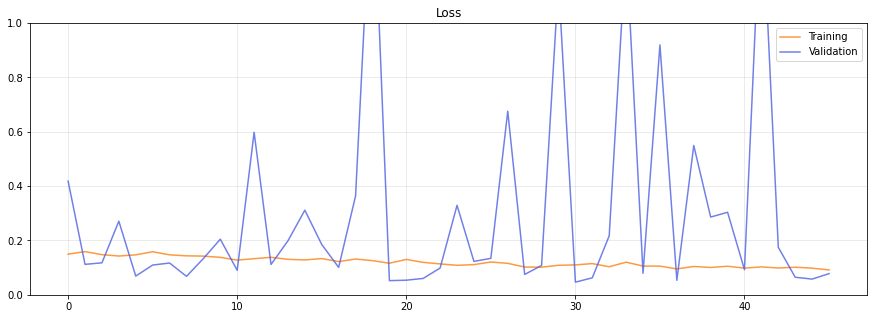

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

{'loss': [0.149474635720253, 0.15897327661514282, 0.14768154919147491, 0.1426321417093277, 0.14698001742362976, 0.15835139155387878, 0.14705054461956024, 0.14331671595573425, 0.14240694046020508, 0.13778282701969147, 0.12762971222400665, 0.13287606835365295, 0.13795018196105957, 0.13052724301815033, 0.12821443378925323, 0.13339351117610931, 0.12221107631921768, 0.13165026903152466, 0.12573868036270142, 0.11616824567317963, 0.13013574481010437, 0.11935460567474365, 0.11363647878170013, 0.10850327461957932, 0.11099949479103088, 0.1206502914428711, 0.11575625836849213, 0.10217580199241638, 0.10159824043512344, 0.10852912068367004, 0.11005132645368576, 0.1148180142045021, 0.10323375463485718, 0.12000219523906708, 0.10565221309661865, 0.10559269785881042, 0.09519115090370178, 0.10426075011491776, 0.10058259963989258, 0.10511866211891174, 0.09812802821397781, 0.10274399816989899, 0.09858380258083344, 0.10149750113487244, 0.09796635061502457, 0.09155431389808655], 'accuracy': [0.9533114433288

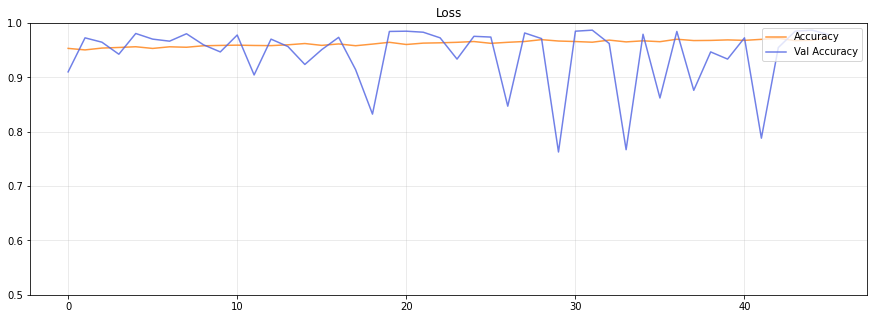

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Val Accuracy', alpha=.8, color='#4D61E2')
plt.ylim(0.5, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

{'loss': [0.149474635720253, 0.15897327661514282, 0.14768154919147491, 0.1426321417093277, 0.14698001742362976, 0.15835139155387878, 0.14705054461956024, 0.14331671595573425, 0.14240694046020508, 0.13778282701969147, 0.12762971222400665, 0.13287606835365295, 0.13795018196105957, 0.13052724301815033, 0.12821443378925323, 0.13339351117610931, 0.12221107631921768, 0.13165026903152466, 0.12573868036270142, 0.11616824567317963, 0.13013574481010437, 0.11935460567474365, 0.11363647878170013, 0.10850327461957932, 0.11099949479103088, 0.1206502914428711, 0.11575625836849213, 0.10217580199241638, 0.10159824043512344, 0.10852912068367004, 0.11005132645368576, 0.1148180142045021, 0.10323375463485718, 0.12000219523906708, 0.10565221309661865, 0.10559269785881042, 0.09519115090370178, 0.10426075011491776, 0.10058259963989258, 0.10511866211891174, 0.09812802821397781, 0.10274399816989899, 0.09858380258083344, 0.10149750113487244, 0.09796635061502457, 0.09155431389808655], 'accuracy': [0.9533114433288

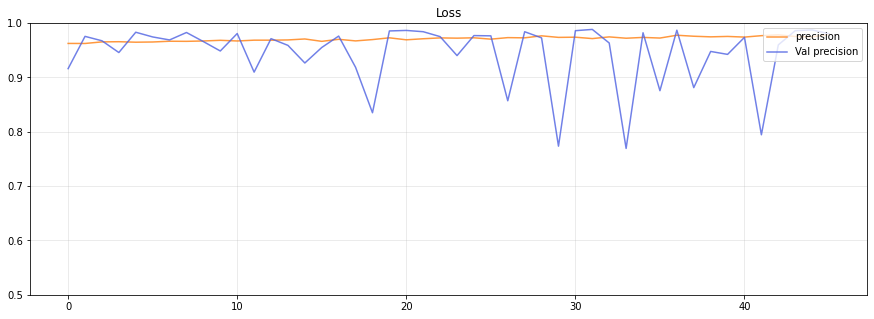

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['precision'], label='precision', alpha=.8, color='#ff7f0e')
plt.plot(history['val_precision'], label='Val precision', alpha=.8, color='#4D61E2')
plt.ylim(0.5, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Show predictions
We evaluate the model looking at the test set predictions

In [ ]:
model = tfk.models.load_model("../gdrive/MyDrive/Challenge1_Mio/ResNetTest/Resnet_model_4")

In [ ]:
print(test_gen.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}


In [ ]:
cd /content

/content


In [ ]:
model_metrics = model.evaluate(test_gen, return_dict=True)
print(model_metrics)

90/90 [==============================] - 256s 3s/step - loss: 0.0869 - accuracy: 0.9818 - precision: 0.9832 - recall: 0.9818
{'loss': 0.0868614912033081, 'accuracy': 0.9818181991577148, 'precision': 0.9831932783126831, 'recall': 0.9818181991577148}


In [ ]:
predictions = model.predict_generator(test_gen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
len(predictions)

1430

In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   
print(true_classes)

[ 0  0  0 ... 13 13 13]


In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

       Apple       1.00      0.95      0.97        99
   Blueberry       0.96      1.00      0.98        47
      Cherry       0.97      0.98      0.97        59
        Corn       1.00      0.98      0.99       122
       Grape       0.96      1.00      0.98       147
      Orange       1.00      0.99      1.00       175
       Peach       0.97      1.00      0.99        99
      Pepper       0.92      0.99      0.95        78
      Potato       0.99      1.00      0.99        72
   Raspberry       0.98      1.00      0.99        53
     Soybean       1.00      1.00      1.00       162
      Squash       0.98      0.98      0.98        58
  Strawberry       0.96      0.99      0.97        69
      Tomato       1.00      0.93      0.96       190

    accuracy                           0.98      1430
   macro avg       0.98      0.99      0.98      1430
weighted avg       0.98      0.98      0.98      1430

